<a href="https://colab.research.google.com/github/dominiksakic/zero_to_hero/blob/main/basics_04_activations_and_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-06-25 23:43:40--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-06-25 23:43:40 (6.12 MB/s) - ‘names.txt’ saved [228145/228145]



In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [8]:
words = open('names.txt', 'r').read().splitlines()

In [9]:
# build vocab and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)

In [10]:
# build the dataset
block_size = 3

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
n_embd = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]

In [12]:
total_param = sum(p.nelement() for p in parameters)
print(f"Total params: {total_param}")

for p in parameters:
  p.requires_grad = True

Total params: 11897


In [13]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact  = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats, lri for finding a good lr
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.9415
  20000/ 200000: 2.5069
  30000/ 200000: 2.7998
  40000/ 200000: 2.0261
  50000/ 200000: 2.5863
  60000/ 200000: 2.3420
  70000/ 200000: 2.0952
  80000/ 200000: 2.3454
  90000/ 200000: 2.2365
 100000/ 200000: 2.1080
 110000/ 200000: 2.3831
 120000/ 200000: 1.9898
 130000/ 200000: 2.4591
 140000/ 200000: 2.1910
 150000/ 200000: 2.1606
 160000/ 200000: 2.1811
 170000/ 200000: 1.7997
 180000/ 200000: 2.0962
 190000/ 200000: 1.8052


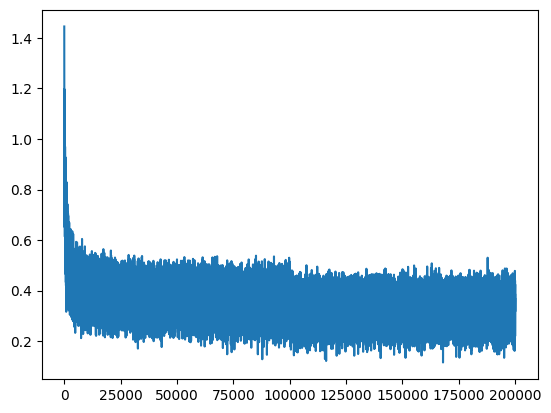

In [14]:
plt.plot(lossi)

In [15]:
@torch.no_grad()
def calculate_loss(X, Y):
  emb = C[X]
  embcat =  emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  return loss.item()

In [16]:
# training loss
train_loss = calculate_loss(Xtr, Ytr)
train_loss

2.127678871154785

In [17]:
# validation loss
dev_loss = calculate_loss(Xdev, Ydev)
dev_loss

2.1750576496124268

In [18]:
# test loss
test_loss = calculate_loss(Xte, Yte)
test_loss

2.1674134731292725

# Exploring the Network initialization
- The first loss recorded is quite high: 27
- If we had a uniform distribution of the next letter, we would expect each letter to have the same out come: 1/27. The loss would equal to something around 3.2. (Take the neg likelihood of 1/27)
- Question:
  - Can we achieve the first loss to be 3.2, or asked differently, what values do the layers have to be initialized to, so that we have a Uniform distribution?

In [19]:
n_embd = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

- Initializing the W2 to excatly 0 can lead to Neuron damage(see below)

In [20]:
total_param = sum(p.nelement() for p in parameters)
print(f"Total params: {total_param}")

for p in parameters:
  p.requires_grad = True

Total params: 11897


In [21]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact  = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats, lri for finding a good lr
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())


      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


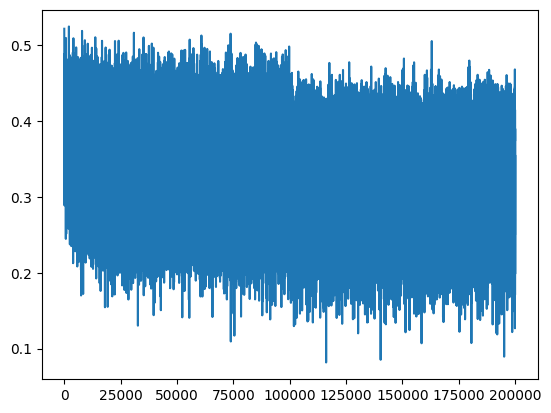

In [22]:
plt.plot(lossi)

In [23]:
# training loss
train_loss = calculate_loss(Xtr, Ytr)
print(f"Training loss: {train_loss}")
# validation loss
dev_loss = calculate_loss(Xdev, Ydev)
print(f"Dev loss: {dev_loss}")
# test loss
test_loss = calculate_loss(Xte, Yte)
print(f"Test loss: {test_loss}")

Training loss: 2.0695888996124268
Dev loss: 2.1310746669769287
Test loss: 2.1328301429748535


# Exploring the activation of the hidden layers!
- squashing the values, can lead to a lot of 0, or 1 -> Which can lead to Dead neuron for the tanh.
- Think about it from the backward pass. Starting from the loss, you flow backwards to the tanh. Than if you have values of -1 or 1 than you kill the Gradient flowing backward. -> Meaning the Gradient stops at the tanh Neuron and all the other Neurons cannot be optimized. (See below for vizulization)


In [24]:
n_embd = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

In [25]:
total_param = sum(p.nelement() for p in parameters)
print(f"Total params: {total_param}")

for p in parameters:
  p.requires_grad = True

Total params: 11897


In [26]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact  = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats, lri for finding a good lr
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.3221


(array([2069.,  144.,  106.,   82.,   59.,   56.,   44.,   30.,   43.,
          26.,   16.,   38.,   16.,   32.,   24.,   14.,   28.,   27.,
          26.,   19.,   24.,   26.,   30.,   14.,   19.,   19.,   22.,
          26.,   18.,   12.,   10.,   33.,   27.,   32.,   17.,   24.,
          30.,   22.,   26.,   29.,   26.,   40.,   29.,   41.,   49.,
          64.,   62.,  100.,  188., 2442.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

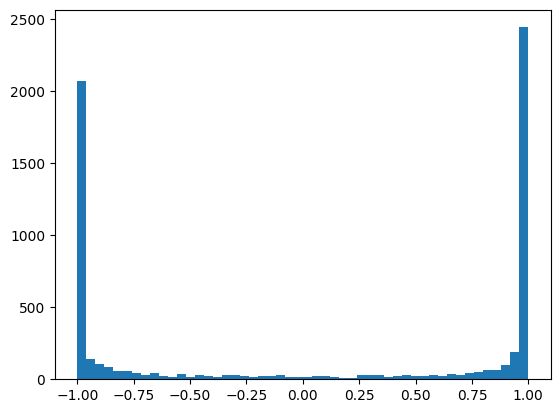

In [27]:
plt.hist(h.view(-1).tolist(), 50)

(array([  2.,   2.,   1.,   4.,   2.,   4.,   6.,  15.,   5.,  25.,  32.,
         49.,  56.,  59.,  92., 119., 134., 197., 195., 221., 257., 275.,
        297., 341., 353., 375., 369., 349., 358., 362., 271., 312., 229.,
        206., 190., 167.,  87., 111.,  72.,  55.,  41.,  22.,  23.,  18.,
         17.,   8.,   5.,   7.,   2.,   1.]),
 array([-19.05793571, -18.31571732, -17.57349892, -16.83128052,
        -16.08906212, -15.34684372, -14.60462532, -13.86240692,
        -13.12018852, -12.37797012, -11.63575172, -10.89353333,
        -10.15131493,  -9.40909653,  -8.66687813,  -7.92465973,
         -7.18244133,  -6.44022293,  -5.69800453,  -4.95578613,
         -4.21356773,  -3.47134933,  -2.72913094,  -1.98691254,
         -1.24469414,  -0.50247574,   0.23974266,   0.98196106,
          1.72417946,   2.46639786,   3.20861626,   3.95083466,
          4.69305305,   5.43527145,   6.17748985,   6.91970825,
          7.66192665,   8.40414505,   9.14636345,   9.88858185,
         10.630800

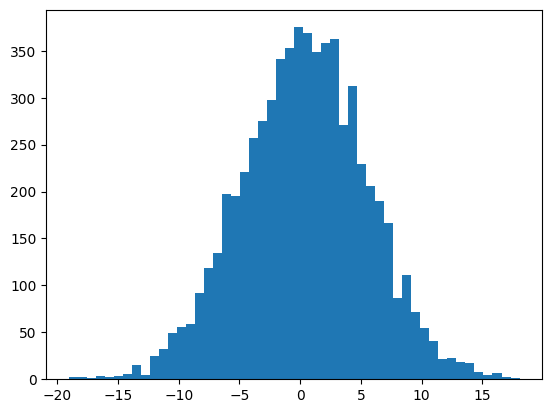

In [28]:
plt.hist(hpreact.view(-1).tolist(), 50)

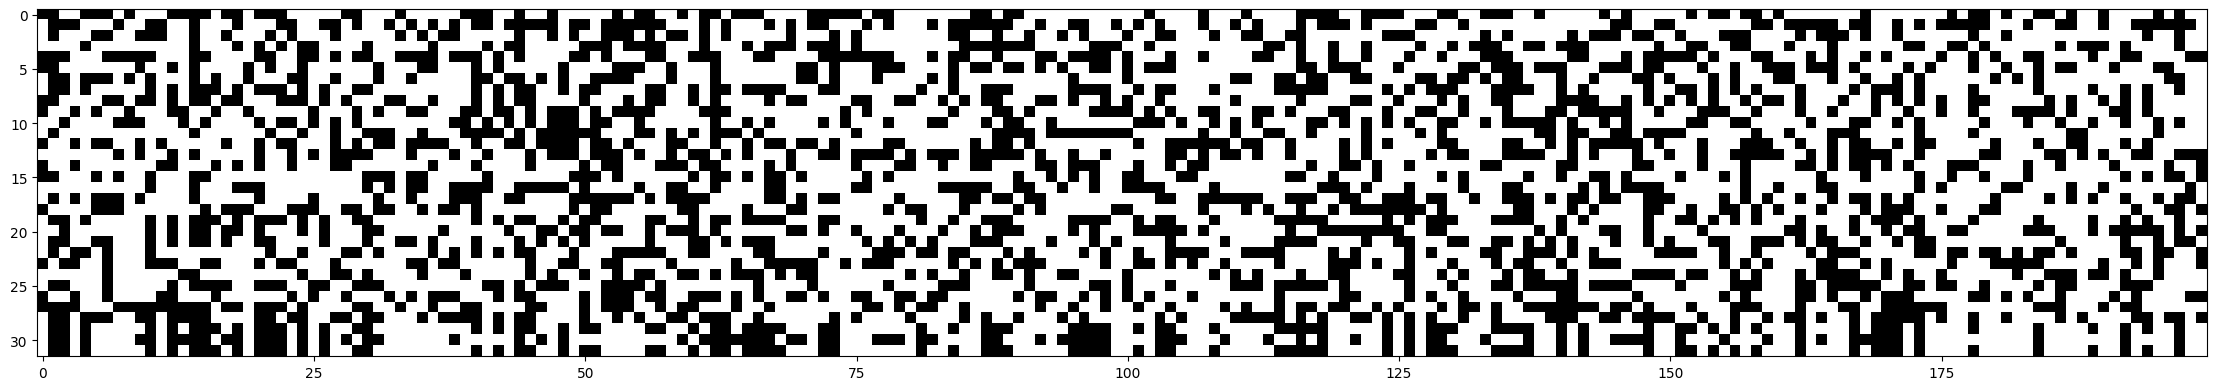

In [29]:
plt.figure(figsize=(28,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

- High activation (> 0.99) gets marked as white
- If at any x-achses you find a strip of pure white, that would mean a unreachable Neuron.
- This can be caused by bad initialization or a too high learning rate, that knocks out Neurons in the backward pass.

In [30]:
n_embd = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2  #<--
b1 = torch.randn(n_hidden,                        generator=g) * 0    #<--
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

In [31]:
total_param = sum(p.nelement() for p in parameters)
print(f"Total params: {total_param}")

for p in parameters:
  p.requires_grad = True

Total params: 11897


In [32]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact  = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats, lri for finding a good lr
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.3134


(array([140., 172., 169., 160., 144., 154., 135., 128., 108., 142.,  93.,
        103., 131., 109., 118.,  95.,  81., 102., 104., 106., 106., 123.,
        109.,  73., 107., 112., 100., 106., 101.,  97., 106., 123., 111.,
        125.,  95., 142., 101.,  98., 123., 122., 141., 125., 165., 161.,
        163., 185., 187., 197., 212., 190.]),
 array([-9.98918831e-01, -9.58983165e-01, -9.19047499e-01, -8.79111832e-01,
        -8.39176166e-01, -7.99240500e-01, -7.59304833e-01, -7.19369167e-01,
        -6.79433501e-01, -6.39497834e-01, -5.99562168e-01, -5.59626502e-01,
        -5.19690835e-01, -4.79755169e-01, -4.39819503e-01, -3.99883837e-01,
        -3.59948170e-01, -3.20012504e-01, -2.80076838e-01, -2.40141171e-01,
        -2.00205505e-01, -1.60269839e-01, -1.20334172e-01, -8.03985059e-02,
        -4.04628396e-02, -5.27173281e-04,  3.94084930e-02,  7.93441594e-02,
         1.19279826e-01,  1.59215492e-01,  1.99151158e-01,  2.39086825e-01,
         2.79022491e-01,  3.18958157e-01,  3.58893

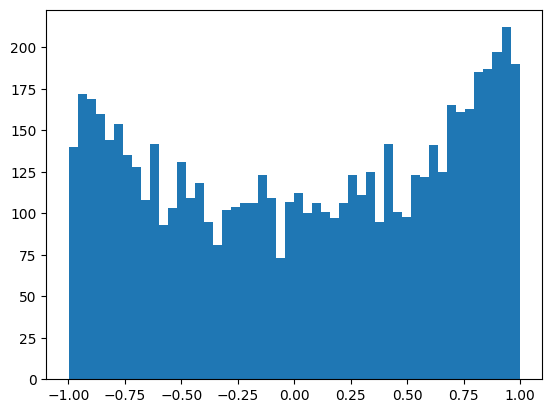

In [33]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   2.,   0.,   1.,   5.,   3.,  11.,   6.,  13.,  10.,  25.,
         40.,  39.,  77.,  64.,  99., 134., 169., 187., 219., 224., 275.,
        308., 311., 355., 369., 379., 357., 366., 333., 292., 284., 287.,
        244., 187., 170., 134., 104.,  82.,  74.,  41.,  30.,  27.,  19.,
         12.,   7.,  12.,   3.,   2.,   7.]),
 array([-3.76114893, -3.61751465, -3.47388037, -3.33024609, -3.1866118 ,
        -3.04297752, -2.89934324, -2.75570896, -2.61207468, -2.4684404 ,
        -2.32480612, -2.18117184, -2.03753756, -1.89390327, -1.75026899,
        -1.60663471, -1.46300043, -1.31936615, -1.17573187, -1.03209759,
        -0.88846331, -0.74482903, -0.60119474, -0.45756046, -0.31392618,
        -0.1702919 , -0.02665762,  0.11697666,  0.26061094,  0.40424522,
         0.54787951,  0.69151379,  0.83514807,  0.97878235,  1.12241663,
         1.26605091,  1.40968519,  1.55331947,  1.69695375,  1.84058804,
         1.98422232,  2.1278566 ,  2.27149088,  2.41512516,  2.55875944,
 

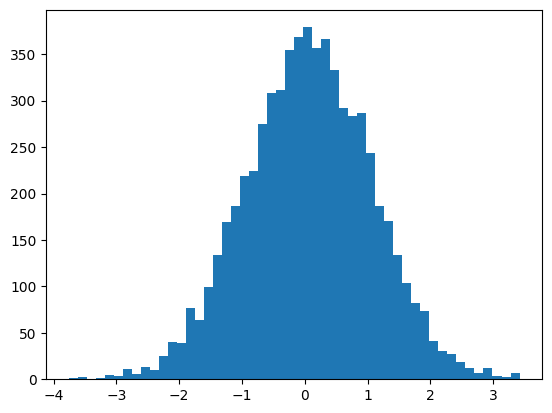

In [34]:
plt.hist(hpreact.view(-1).tolist(), 50)

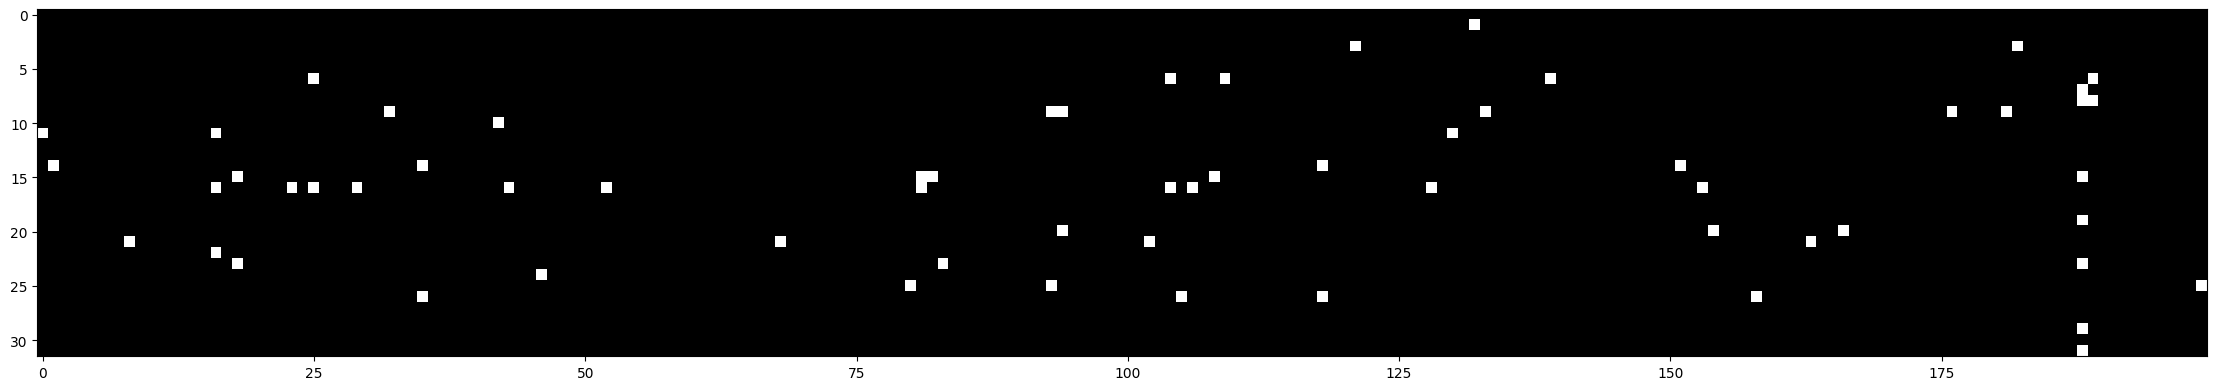

In [35]:
plt.figure(figsize=(28,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# Experiment Initialize to Zero and Visualize the Activations.

In [36]:
n_embd = 10
n_hidden = 200


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0 #<--
b1 = torch.randn(n_hidden,                        generator=g) * 0 #<--
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0 #<--
b2 = torch.randn(vocab_size,                      generator=g) * 0 #<--

parameters = [C, W1, b1, W2, b2]


total_param = sum(p.nelement() for p in parameters)
print(f"Total params: {total_param}")

for p in parameters:
  p.requires_grad = True

  max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact  = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats, lri for finding a good lr
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

Total params: 11897
      0/ 200000: 3.2958
  10000/ 200000: 2.6793
  20000/ 200000: 2.8210
  30000/ 200000: 3.0941
  40000/ 200000: 3.0673
  50000/ 200000: 3.0884
  60000/ 200000: 2.8090
  70000/ 200000: 2.6637
  80000/ 200000: 2.6951
  90000/ 200000: 2.7917
 100000/ 200000: 2.5930
 110000/ 200000: 3.0857
 120000/ 200000: 2.8063
 130000/ 200000: 2.8613
 140000/ 200000: 2.8347
 150000/ 200000: 2.8381
 160000/ 200000: 2.8990
 170000/ 200000: 2.6623
 180000/ 200000: 2.7992
 190000/ 200000: 2.8359


(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 6400.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
        -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
        -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
         0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
         0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
         0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]),
 <BarContainer object of 50 artists>)

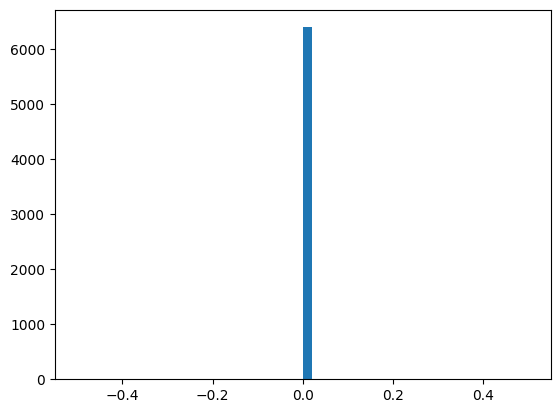

In [37]:
plt.hist(h.view(-1).tolist(), 50)

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 6400.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
        -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
        -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
         0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
         0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
         0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]),
 <BarContainer object of 50 artists>)

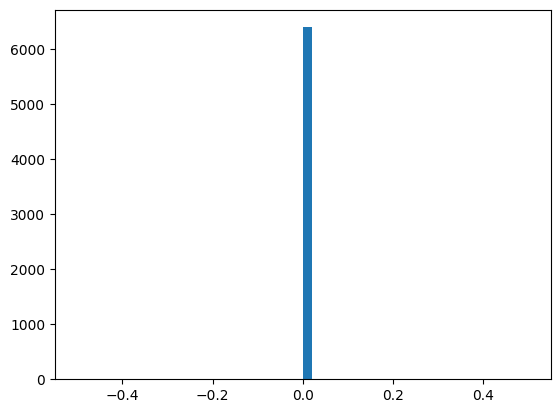

In [38]:
plt.hist(hpreact.view(-1).tolist(), 50)

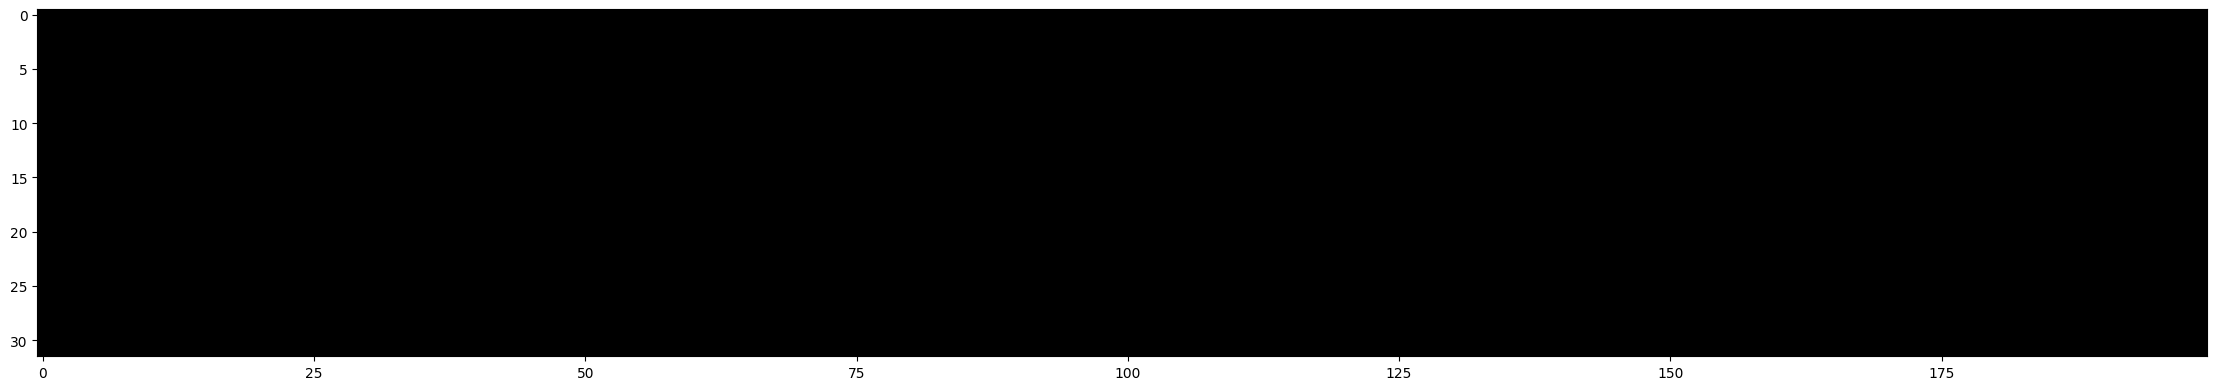

In [39]:
plt.figure(figsize=(28,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [40]:
# training loss
train_loss = calculate_loss(Xtr, Ytr)
print(f"Training loss: {train_loss}")
# validation loss
dev_loss = calculate_loss(Xdev, Ydev)
print(f"Dev loss: {dev_loss}")
# test loss
test_loss = calculate_loss(Xte, Yte)
print(f"Test loss: {test_loss}")

Training loss: 2.822659730911255
Dev loss: 2.8209733963012695
Test loss: 2.8255531787872314


# Setting initialization
- no magic number is the goal!
- See below how the std is changing after doing a multiplication, we want the std to stay the same.
- Further reading: https://arxiv.org/pdf/1502.01852
- practical use: https://docs.pytorch.org/docs/stable/nn.init.html

tensor(0.0069) tensor(1.0121)
tensor(0.0354) tensor(1.9062)


(array([1.36470429e-05, 4.09412353e-05, 0.00000000e+00, 6.82353033e-05,
        1.36470607e-04, 2.04705910e-04, 3.00235335e-04, 9.68940046e-04,
        1.48753155e-03, 2.68846745e-03, 4.43529471e-03, 6.40047145e-03,
        1.02898837e-02, 1.40291601e-02, 2.10574146e-02, 3.04329453e-02,
        4.51581237e-02, 6.14800083e-02, 8.17867281e-02, 1.04440955e-01,
        1.31571312e-01, 1.53174609e-01, 1.78789909e-01, 2.01744760e-01,
        2.16633159e-01, 2.19144785e-01, 2.08731521e-01, 1.96148948e-01,
        1.73208719e-01, 1.52028058e-01, 1.28091478e-01, 1.02448351e-01,
        7.89754373e-02, 6.13026763e-02, 4.57448878e-02, 3.24936937e-02,
        2.26404442e-02, 1.54893937e-02, 9.78495523e-03, 6.55058059e-03,
        3.82118196e-03, 2.48376181e-03, 1.37835133e-03, 7.36942235e-04,
        4.50353588e-04, 1.63764089e-04, 1.91059098e-04, 2.72941568e-05,
        2.72940148e-05, 1.36470784e-05]),
 array([-9.30009937, -8.93371964, -8.56734085, -8.20096111, -7.83458185,
        -7.46820259, 

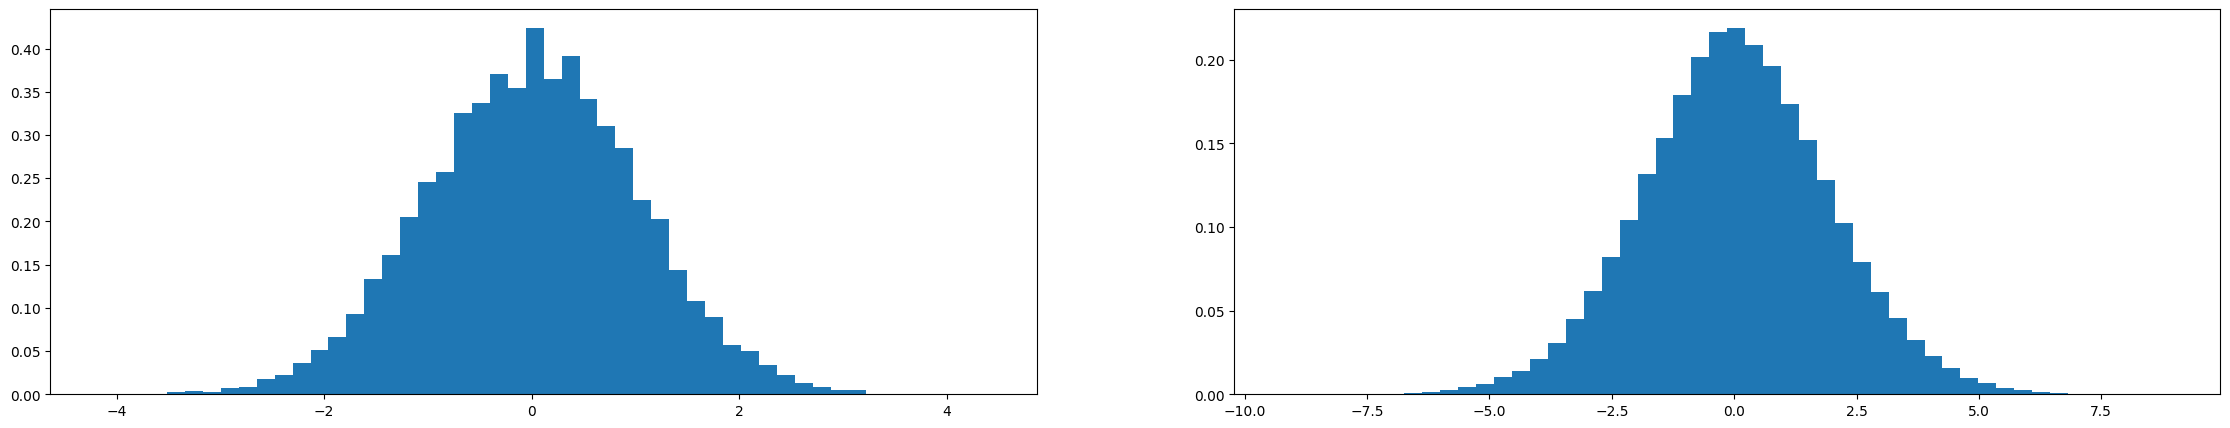

In [41]:
x = torch.randn(1000, 10)
w = torch.rand(10, 200) # <-- What do we multiply it with to keep the std?
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(28, 5))
plt.subplot(121)
plt.hist(x.view(-1), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1), 50, density=True)

tensor(0.0022) tensor(1.0020)
tensor(0.0038) tensor(0.5612)


(array([1.44387208e-04, 4.81290693e-05, 1.92516277e-04, 3.36903485e-04,
        5.29419762e-04, 1.54013022e-03, 2.31019533e-03, 3.80219647e-03,
        6.20864994e-03, 9.43330840e-03, 1.44387208e-02, 2.07436289e-02,
        3.15245404e-02, 4.88991344e-02, 6.85839237e-02, 9.79907850e-02,
        1.35723975e-01, 1.87318338e-01, 2.53495808e-01, 3.36807613e-01,
        4.14920706e-01, 5.03670710e-01, 5.92468843e-01, 6.52582050e-01,
        7.08844932e-01, 7.38492439e-01, 7.28818496e-01, 7.02588153e-01,
        6.54122180e-01, 5.76441863e-01, 4.84322824e-01, 4.03562246e-01,
        3.25545025e-01, 2.50415547e-01, 1.88858468e-01, 1.46264242e-01,
        1.05498920e-01, 7.63327039e-02, 5.25088146e-02, 3.44123635e-02,
        2.20430631e-02, 1.79040549e-02, 1.04921130e-02, 6.49743926e-03,
        4.09096150e-03, 2.45458817e-03, 9.62579176e-04, 2.88775078e-04,
        2.40644794e-04, 9.62583595e-05]),
 array([-2.69874692e+00, -2.59485960e+00, -2.49097228e+00, -2.38708496e+00,
        -2.2831976

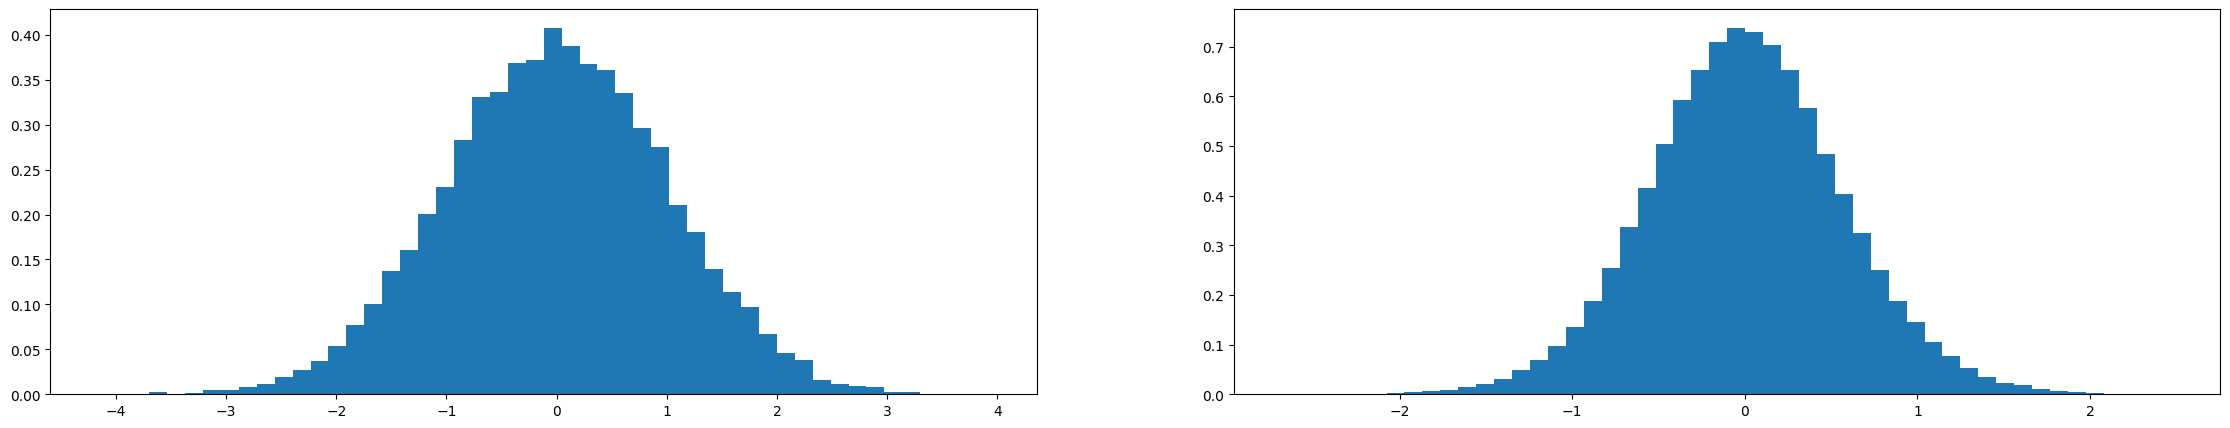

In [42]:
x = torch.randn(1000, 10)
w = torch.rand(10, 200) / 10 ** 0.5 # This is depending on the operation done read paper, docu.
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(28, 5))
plt.subplot(121)
plt.hist(x.view(-1), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1), 50, density=True)

In [47]:
# Torchifying Code:
class Linear:
  def __init__(self,fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) /fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [49]:
n_embd = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=True), Tanh(),
    Linear(n_hidden, vocab_size, bias=True),
]

with torch.no_grad():
  # last layer: make les confident
  layers[-1].weight *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [50]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.3150
  10000/ 200000: 2.4845
  20000/ 200000: 2.1417
  30000/ 200000: 2.1024
  40000/ 200000: 2.0855
  50000/ 200000: 1.7763
  60000/ 200000: 2.0431
  70000/ 200000: 2.2053
  80000/ 200000: 1.7218
  90000/ 200000: 2.0493
 100000/ 200000: 1.8068
 110000/ 200000: 2.2504
 120000/ 200000: 2.3371
 130000/ 200000: 2.2744
 140000/ 200000: 1.7778
 150000/ 200000: 2.1001
 160000/ 200000: 2.0925
 170000/ 200000: 2.1323
 180000/ 200000: 1.7284
 190000/ 200000: 2.0832


layer 1 (      Tanh): mean +0.03, std 0.82, saturated: 39.77%


Text(0.5, 1.0, 'activation distribution')

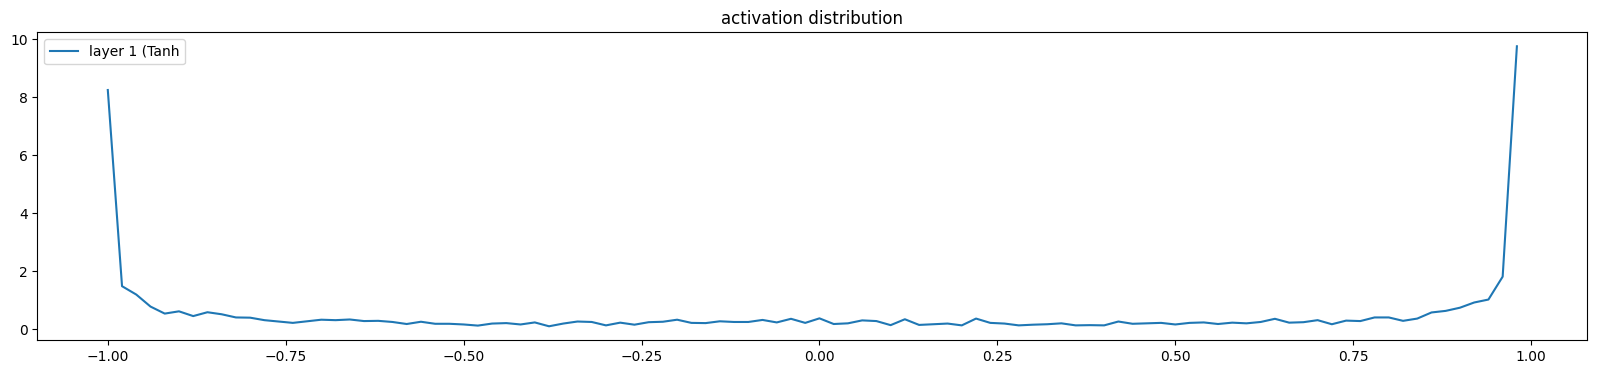

In [51]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000007, std 6.202579e-03


Text(0.5, 1.0, 'gradient distribution')

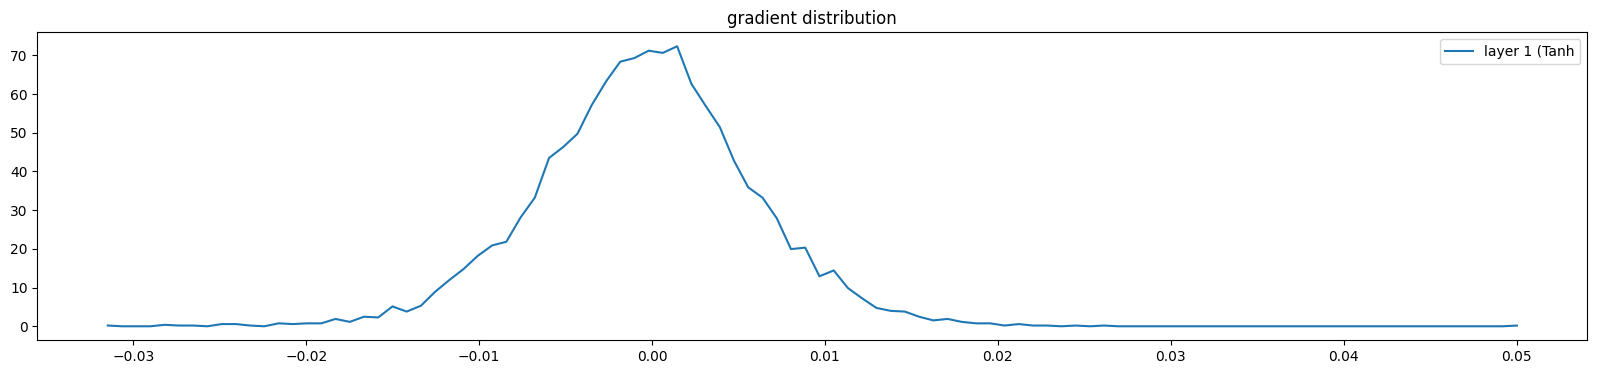

In [52]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.002912 | std 3.042792e-02 | grad:data ratio 2.883494e-02
weight  (30, 200) | mean -0.000048 | std 1.297333e-02 | grad:data ratio 2.504874e-02
weight  (200, 27) | mean +0.000000 | std 2.394783e-02 | grad:data ratio 1.012267e-01


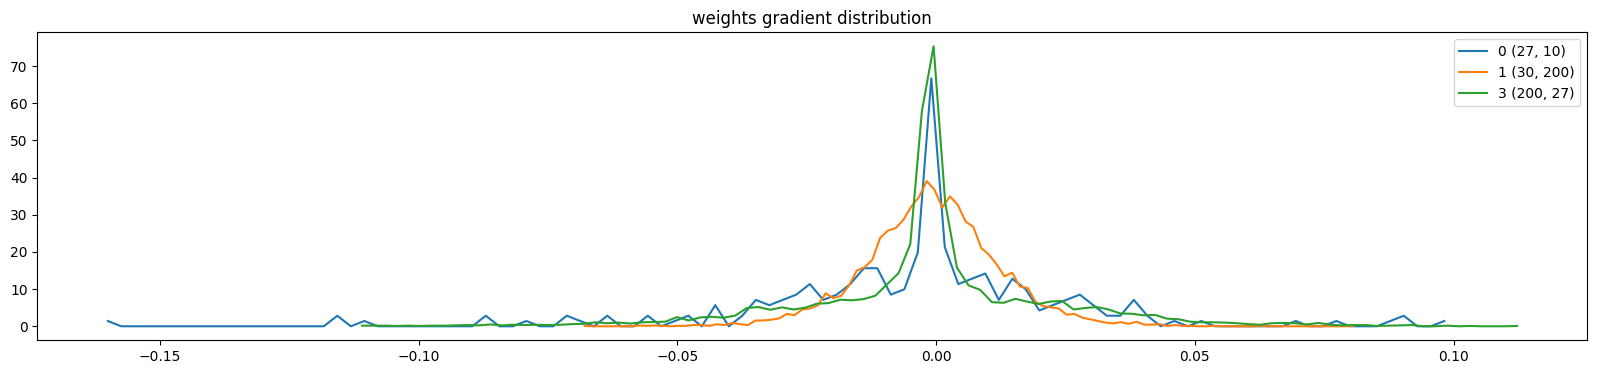

In [53]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

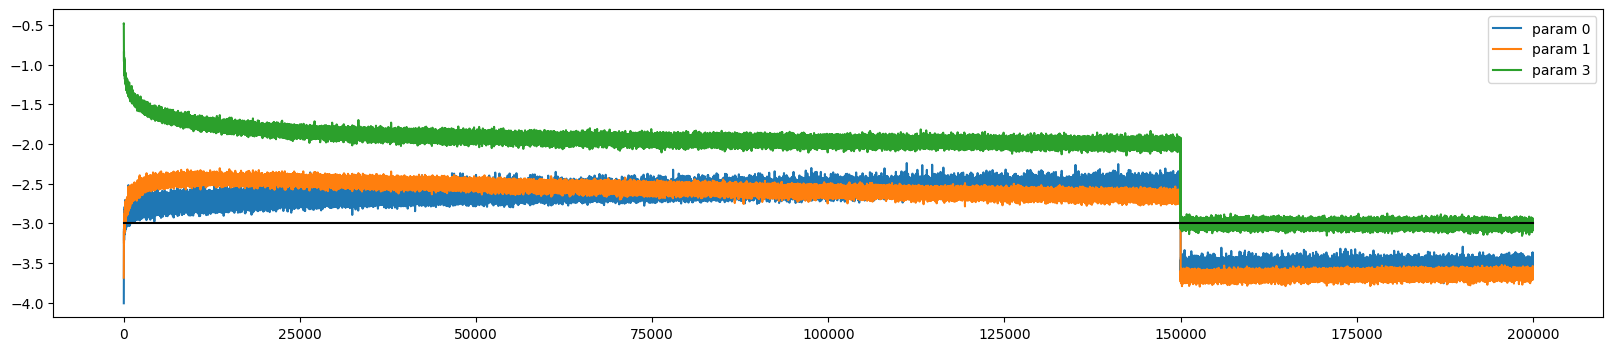

In [54]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);